<a href="https://colab.research.google.com/github/pinwap/QuantumAI/blob/main/QNN_lecture6_11_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit  qiskit-machine-learning qiskit-algorithms
!pip install qiskit['visualization']

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
iris = load_iris()

X = iris.data
y = iris.target

scaler = MinMaxScaler(feature_range = (0, np.pi))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
num_qubits = 4

In [ ]:
# เขียน feature map เองไม่ใช้ ZZFeatureMap

from qiskit.circuit import ParameterVector

def feature_map(n_qubits, reps=1, entanglement='linear'):
    x = ParameterVector('x', n_qubits) #parameter vector นี้เก็บข้อมูลกี่ qubit
    qc = QuantumCircuit(num_qubits, name = 'FeatureMap')

    # ทำซ้ำวงจรตามจำนวน repeats
    for i in range(reps):

      for q in range(n_qubits):
        qc.rz(x[q], q) # rotation gate Z

        if entanglement == 'linear':
          for q in range(n_qubits - 1):
            qc.cx(q, q + 1) #ทำ cnot gate กับคิวบิตทุกตัวแบบ linear เชื่อมq0-q1, q1-q2,...

        elif entanglement == 'full': #full คือเอาตัวสุดท้ายทำกลับมาที่ตัวแรก qn-q0
          for j in range(n_qubits):
            for k in range(j + 1, n_qubits):
              qc.cx(j, k)

    return qc

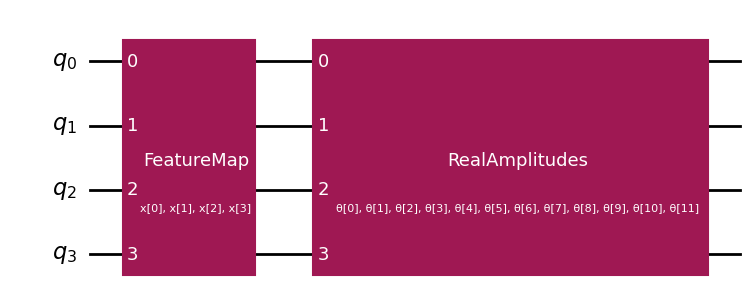

In [ ]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit import QuantumCircuit

# สร้างวงจร data encoding
# feature_map = ZZFeatureMap(feature_dimension = num_qubits, reps = 1, entanglement = 'linear')
feature_map = feature_map(num_qubits, reps = 1, entanglement = 'linear')

# วงจร parameterize quantum circuit
ansatz = RealAmplitudes(num_qubits, reps = 2, entanglement='linear')

# เอาทั้งสองวงจรด้านบนมารวมกัน ใน quantum circuit
qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))

qc.draw('mpl')

In [ ]:
input_params = list(feature_map.parameters)
weight_params = list(ansatz.parameters)

In [ ]:
output_shape = 3

In [ ]:
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms.gradients import ParamShiftSamplerGradient #คลาสที่ใช้ในการทำgradient
from qiskit_machine_learning.neural_networks import SamplerQNN #คลาสที่ใช้ในการสร้าง neural network

In [ ]:
sampler = StatevectorSampler()
grad = ParamShiftSamplerGradient(sampler)

interpret = lambda x: x%3 #mod 3 = จัด input ออกเป็น3กลุ่ม

qnn = SamplerQNN(
    circuit = qc,
    input_params = input_params,
    weight_params = weight_params,
    sampler = sampler,
    interpret = interpret,
    output_shape = output_shape,
    input_gradients = False
)

In [ ]:
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

model = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=COBYLA(maxiter=150),
    one_hot=True, #output
    loss = 'cross_entropy'
)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test) #คำตอบที่โมเดลทำนายออกมา
# เทียบค่า acuracy กับ y_test คำตอบจริง
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.5777777777777777
              precision    recall  f1-score   support

           0       0.67      0.63      0.65        19
           1       0.80      0.31      0.44        13
           2       0.45      0.77      0.57        13

    accuracy                           0.58        45
   macro avg       0.64      0.57      0.55        45
weighted avg       0.64      0.58      0.57        45

